In [61]:
#Importing Libraries
import numpy as np
import pandas as pd
import torch.nn as nn
import torch

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import math
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import Perceptron
from sklearn.model_selection import  train_test_split
from tqdm.notebook import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns


# Dataset

In [62]:
#Load dataset JNJ
stock_df = pd.read_csv('JNJ.csv')

print(stock_df.info())
stock_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14663 entries, 0 to 14662
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14663 non-null  object 
 1   Open       14663 non-null  float64
 2   High       14663 non-null  float64
 3   Low        14663 non-null  float64
 4   Close      14663 non-null  float64
 5   Adj Close  14663 non-null  float64
 6   Volume     14663 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 802.0+ KB
None


,Open,High,Low,Close,Adj Close,Volume
count,14663.000000,14663.000000,14663.000000,14663.000000,1.466300e+04,1.466300e+04
mean,31.996048,32.297808,31.804296,32.060827,2.402043e+01,5.484288e+06
std,39.530036,39.752018,39.210176,39.491726,3.572575e+01,5.092454e+06
min,0.000000,0.146991,0.142361,0.142361,4.038145e-07,0.000000e+00
25%,1.829427,1.848958,1.815104,1.830729,2.478828e-05,1.521600e+06
50%,9.375000,9.500000,9.312500,9.406250,3.242710e+00,4.713600e+06
75%,59.490002,59.950001,59.000000,59.514999,4.003965e+01,7.776350e+06
max,154.250000,154.500000,152.740005,153.990005,1.530143e+02,1.446720e+08


In [63]:
#Set col Date as index
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.000000,0.223380,0.222222,0.223380,6.281419e-07,0
1962-01-03,0.000000,0.221065,0.219907,0.219907,6.183778e-07,345600
1962-01-04,0.000000,0.221065,0.217593,0.217593,6.118684e-07,216000
1962-01-05,0.000000,0.215856,0.214120,0.214120,6.021048e-07,129600
1962-01-08,0.000000,0.212384,0.210648,0.210648,5.923411e-07,172800
...,...,...,...,...,...,...
2020-03-26,120.570000,127.099998,120.379997,126.570000,1.265700e+02,15066800
2020-03-27,121.650002,127.620003,120.580002,123.160004,1.231600e+02,12133200
2020-03-30,128.460007,133.990005,127.500000,133.009995,1.330100e+02,21754000


In [64]:
#Set seed
torch.manual_seed(1357)

In [65]:
#Set device
def is_cuda_available():
    return torch.cuda.is_available()

def load_to_device(obj):
    device_type = 'cpu'
    if is_cuda_available():
        device_type = 'cuda'
    device = torch.device(device_type)
    if isinstance(obj, (list,tuple)):
      return [data.to(device, non_blocking=True) for data in obj]
    return obj.to(device, non_blocking = True)

def get_dataloader_object(dataset, batch_size):
    kwargs = {'num_workers': 2, 'pin_memory': True} if is_cuda_available() else {}
    return  DataLoader(dataset, batch_size = batch_size, shuffle=False, **kwargs)

#Function to normalise data
def normalise_df(data_frame, cols, min_max_scaler):
  normalised_df = pd.DataFrame()
  normalised_df[cols] = min_max_scaler.fit_transform(data_frame[cols])
  return normalised_df

#Function to split df to training,testing and validation set
def split_train_test_val_df(df, test_size = 0.2, val_size = 0.2):
  train_df, test_df = train_test_split(df, test_size= test_size, shuffle = False)
  train_df, val_df = train_test_split(train_df, test_size= test_size, shuffle = False)
  return (train_df, val_df, test_df)

In [66]:
#Create Dataset Class
class StockDataClass(Dataset):
  def __init__(self, normalised_df, target_list, pred_seq_size = 1, input_seq_size = 10):

    self.input_seq_size = input_seq_size
    self.pred_seq_size = pred_seq_size

    #to update for multiple paths and join each date to form a tensor (3D)
    stockData_df = normalised_df

    #Create Training Data
    training_df = self.getTrainingData(stockData_df, pred_seq_size)
    training_tensor = self.getTensor(stockData_df)

    #Create Target Data
    target_df = self.getTargetLabels(stockData_df, target_list, pred_seq_size)
    target_tesnor = self.getTensor(target_df)

    self.training_data = training_tensor
    self.target_labels = target_tesnor

  def __getitem__(self, i):
    return self.training_data[i : i + self.input_seq_size, :].float(),self.target_labels[i + self.input_seq_size : i + self.input_seq_size + self.pred_seq_size, :].float() 
    
  def __len__(self):
    return self.training_data.shape[0] - self.input_seq_size - self.pred_seq_size

  def getTensor(self, stockData_df):
    _tensor = torch.from_numpy(stockData_df.values)
    return _tensor

  def getTrainingData(self, stockData_df, future_steps):
    trainingDataDf = stockData_df.copy(deep = True)
    return trainingDataDf.astype('float64')

  def getTargetLabels(self, stockData_df, targetLabels_list, future_steps):
    targetData_df = pd.DataFrame()
    assert type(targetLabels_list) == list, 'targetLabels_list should be a list'

    for cols_names in targetLabels_list:
      targetData_df[cols_names] = stockData_df[cols_names]
    return targetData_df.astype('float64')


In [67]:
#Function to get training, validation and testing dataloader object
def getTrainTestVal_Dataloader(stock_df, training_cols, pred_cols, min_max_scaler, pred_seq_size = 1, batch_size = 20):

  #to normalise data for training_cols
  normalised_stock_df = normalise_df(stock_df, training_cols, min_max_scaler)

  #split data(except date index)
  train_df,val_df,test_df = split_train_test_val_df(normalised_stock_df)
  print('Shape of training df', train_df.shape)
  print('Shape of validation df', val_df.shape)
  print('Shape of testing df', test_df.shape)

  training_dataset = StockDataClass(train_df, pred_cols, pred_seq_size)
  val_dataset = StockDataClass(val_df, pred_cols, pred_seq_size)
  test_dataset = StockDataClass(test_df, pred_cols, pred_seq_size)

  train_dataloader = get_dataloader_object(training_dataset, batch_size)
  val_dataloader = get_dataloader_object(val_dataset, batch_size)
  test_dataloader = get_dataloader_object(test_dataset, batch_size)

  return train_dataloader,val_dataloader,test_dataloader

In [68]:
#Create DataLoader object for experiments
training_cols_one_to_one = ['Close']
pred_cols_one_to_one = ['Close']

training_cols_many_to_one = ['Close', 'High', 'Low','Adj Close', 'Volume']
pred_cols_many_to_one = ['Close']

min_max_scaler_one_to_one = MinMaxScaler(feature_range=(0, 1)) 
min_max_scaler_many_to_one = MinMaxScaler(feature_range=(0, 1)) 

train_one_to_one_dl ,val_one_to_one_dl, test_one_to_one_dl = getTrainTestVal_Dataloader(stock_df[0:6000], 
                                                                                        training_cols_one_to_one, 
                                                                                        pred_cols_one_to_one, 
                                                                                        min_max_scaler_one_to_one, 
                                                                                        pred_seq_size = 1, 
                                                                                        batch_size = 20)

train_many_to_one_dl,val_many_to_one_dl, test_many_to_one_dl = getTrainTestVal_Dataloader(stock_df[:6000], 
                                                                                          training_cols_many_to_one, 
                                                                                          pred_cols_many_to_one, 
                                                                                          min_max_scaler_many_to_one, 
                                                                                          pred_seq_size = 1, 
                                                                                          batch_size = 20)

Shape of training df (3840, 1)
Shape of validation df (960, 1)
Shape of testing df (1200, 1)
Shape of training df (3840, 5)
Shape of validation df (960, 5)
Shape of testing df (1200, 5)


# RNNs Functions

In [69]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Base Class for RNN and LSTM Models
class LearningSteps(nn.Module):
  #Function to train each batch
  def training_step(self, batch):
    input, target = batch
    out, hidden = self(input.float())
    loss_func = nn.MSELoss()
    training_loss = loss_func(out,target[:,-1,:])
    return training_loss, out

  def validation_step(self, val_batch):
    val_input, val_target = val_batch
    out, hidden = self(val_input.float())
    loss_func = nn.MSELoss()
    val_loss = loss_func(out, val_target)
    return {'val_loss': val_loss.detach()}

  @torch.no_grad()
  def predict(self, input):
      out, hidden = self(input.float())
      return out

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    return {'val_loss': epoch_loss.item()} 

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_MSE: {:.4f}, val_MSE: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))
    
class VanillaRNN(LearningSteps):
  def __init__(self, input_size, output_size, hidden_size, n_layers):
    super().__init__()
    
    #Create internal variables
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    #Define RNN layer
    #RNN Args
    kwargs = {'input_size':input_size, 'hidden_size':hidden_size, 
              'num_layers':n_layers,'nonlinearity':'tanh','bias':True, 
              'batch_first':False, 'dropout':0, 'bidirectional':False}

    self.rnn = nn.RNN(**kwargs)   
    #set fully connected layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
      batch_size = x.size(1)
      #to initialize hidden state for first input 
      hidden = self.init_hidden(batch_size)
      out, hidden = self.rnn(x, hidden)
      out = self.fc(out[:, -1, :])
      return out, hidden
    
  def init_hidden(self, batch_size):
      hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
      return hidden

class LSTM(DeepLearningSteps):
  def __init__(self, input_size, output_size, hidden_size, n_layers):
    super().__init__()

    #Create internal variables
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.input_size = input_size

    #Define LSTM layer
    #LSTM Args
    kwargs = {'input_size': self.input_size, 'hidden_size': self.hidden_size, 
              'num_layers': self.n_layers,'bias': True, 
              'batch_first':False, 'dropout':0, 'bidirectional':False}

    self.lstm = nn.LSTM(**kwargs)   
    #set fully connected layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = x
    h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size) 
    c0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size)

    out, (hn, cn) = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out, hn

### Training RNNs

In [81]:
#Function to get RNN Model
def getRNNModel(input_size, output_size, hidden_size, n_layer = 1):
  model = VanillaRNN(input_size= input_size, output_size= output_size, hidden_size = hidden_size, n_layers = n_layer)
  model = load_to_device(model)
  return model

#Function to get LSTM Model
def getLSTMModel(input_size, output_size, hidden_size, n_layer = 1):
  model = LSTM(input_size= input_size, output_size= output_size, hidden_size = hidden_size, n_layers = n_layer)
  model = load_to_device(model)
  return model

#Function to plot training data
def plot_training_loss(training_Results):
  train_loss = [ out['train_loss'] for out in training_Results]
  val_loss = [ out['val_loss'] for out in training_Results]
  plt.plot(train_loss, label = 'Training Loss')
  plt.plot(val_loss, '-o', label = 'Validation Loss')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  return

#Function to start training model
def start_training(model, optimizer, train_dataloader, val_dataloader, epoch = 100):
  history = []
  for epoch in range(1, epoch + 1):
    model.train()
    training_losses = []
    training_predictions = []
    #Training steps
    for batch_idx, batch in enumerate(train_dataloader): 
      input, target = batch
      batch = load_to_device(batch)
      training_loss,training_pred = model.training_step(batch)
      training_predictions.append(training_pred)
      training_losses.append(training_loss)
      training_loss.backward()
      optimizer.step() 
      optimizer.zero_grad() 
    #Validation steps for each epoch
    epochEndResults = evaluate(model, val_dataloader)
    epochEndResults['train_loss'] = torch.stack(training_losses).mean().item()
    history.append(epochEndResults) 
    if epoch % 5 == 0:
      model.epoch_end(epoch, epochEndResults)
  return history

def plot_test_graph(prediction, target, title, pred_col):
  plt.figure(figsize = (10,7))
  plt.plot(target, label = "Real price")
  plt.plot(prediction, label = "Predicted price")
  plt.title(f"Real price vs Prediction {title}", fontsize = 15)
  plt.xlabel("Time", fontsize = 12)
  plt.ylabel(pred_col, fontsize = 12)
  plt.legend(fontsize= 12)
  plt.show()
  return 

#Function to print test result of each model 
@torch.no_grad()
def get_test_results(model, test_dl, title):
    model.eval()
    outputs = []
    pred_list = []
    predictions = []
    target_list = []
    target_labels = []
    outputs = [model.validation_step(batch) for batch in test_dl]
    for index, batch in enumerate(test_dl):
      input, target = batch
      a = model.predict(input)
      pred_list.append(a[:,0].detach().numpy())
      target_list.append(target[:,0,0].detach().numpy())
    for items in pred_list:
      predictions.extend(items)
    for items in target_list:
      target_labels.extend(items)

    mse_loss = model.validation_epoch_end(outputs)['val_loss']
    rmse_loss = np.sqrt(mse_loss)
    print(f'Test Result: MSE: {mse_loss}, RMSE: {rmse_loss} \n\n')
    plot_test_graph(predictions, target_labels, title, pred_cols_one_to_one[0])
    
    return 

# Experiments

### RNN

/Users/natashakwan/opt/anaconda3/envs/tf/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/natashakwan/opt/anaconda3/envs/tf/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 1, 1])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [5], train_MSE: 0.0118, val_MSE: 0.0030
Epoch [10], train_MSE: 0.0128, val_MSE: 0.0025
Epoch [15], train_MSE: 0.0008, val_MSE: 0.0006
Epoch [20], train_MSE: 0.0008, val_MSE: 0.0007
Epoch [25], train_MSE: 0.0012, val_MSE: 0.0009
Epoch [30], train_MSE: 0.0015, val_MSE: 0.0009
Epoch [35], train_MSE: 0.0011, val_MSE: 0.0005
Epoch [40], train_MSE: 0.0013, val_MSE: 0.0007
Epoch [45], train_MSE: 0.0013, val_MSE: 0.0007
Epoch [50], train_MSE: 0.0012, val_MSE: 0.0006


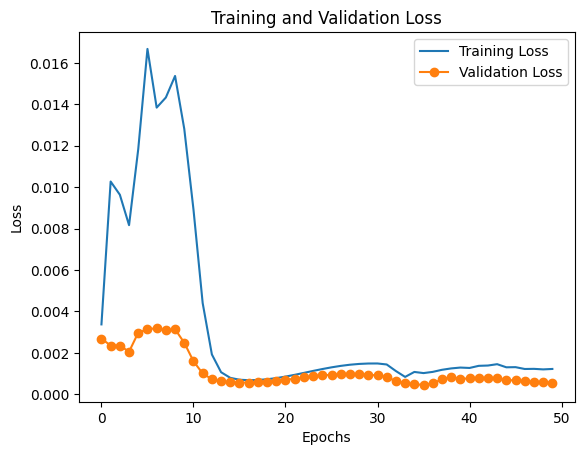

Test Result: MSE: 0.02150801755487919, RMSE: 0.1466561200730443 




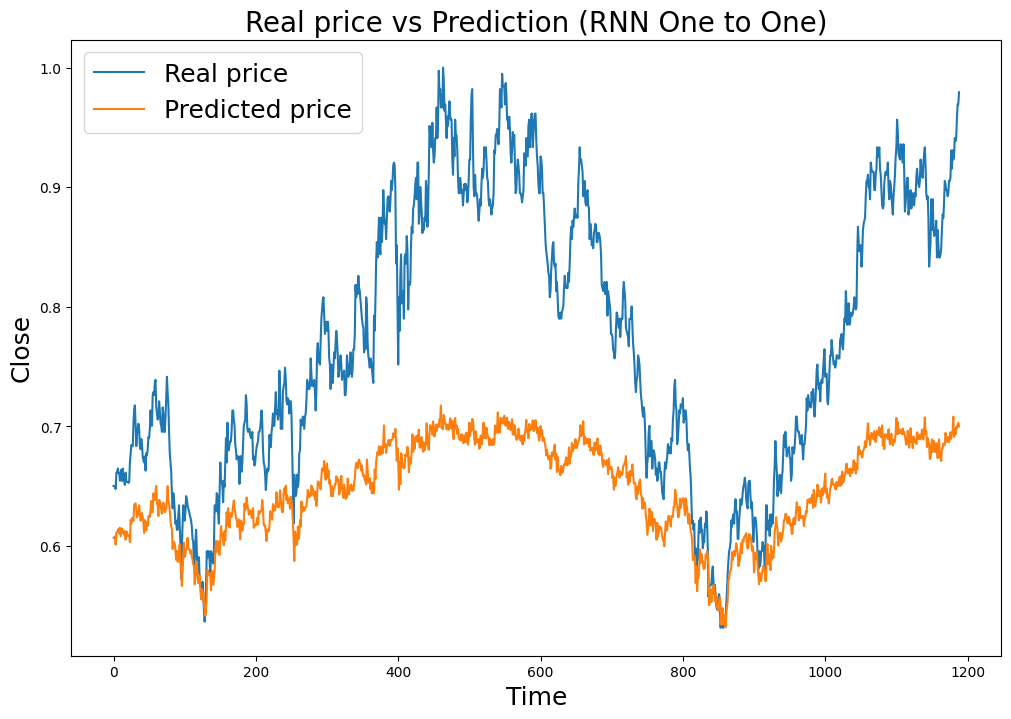

In [71]:
#Experiment 1a : One to One
input_size_rnn_exp_1 = len(training_cols_one_to_one)
output_size_rnn_exp_1 = len(pred_cols_one_to_one)
hidden_size_rnn_exp_1 = 25
n_layer_rnn_1 = 2

train_one_to_one_dl ,val_one_to_one_dl, test_one_to_one_dl 

#Model 1
model_1 = getRNNModel(input_size_rnn_exp_1, 
                      output_size_rnn_exp_1, 
                      hidden_size_rnn_exp_1, 
                      n_layer = n_layer_rnn_1)

lr = 0.001
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
rnnresult_1 = start_training(model_1, optimizer_1, 
                          train_one_to_one_dl, 
                          val_one_to_one_dl, 
                          epoch = 50)

#Plot training loss
plot_training_loss(rnnresult_1)

#Plot test results
get_test_results(model_1, test_one_to_one_dl, '(RNN One to One)')

Epoch [5], train_MSE: 0.0064, val_MSE: 0.0016
Epoch [10], train_MSE: 0.0029, val_MSE: 0.0013
Epoch [15], train_MSE: 0.0011, val_MSE: 0.0012
Epoch [20], train_MSE: 0.0016, val_MSE: 0.0018
Epoch [25], train_MSE: 0.0022, val_MSE: 0.0020
Epoch [30], train_MSE: 0.0025, val_MSE: 0.0018
Epoch [35], train_MSE: 0.0022, val_MSE: 0.0015
Epoch [40], train_MSE: 0.0019, val_MSE: 0.0011
Epoch [45], train_MSE: 0.0019, val_MSE: 0.0010
Epoch [50], train_MSE: 0.0015, val_MSE: 0.0008


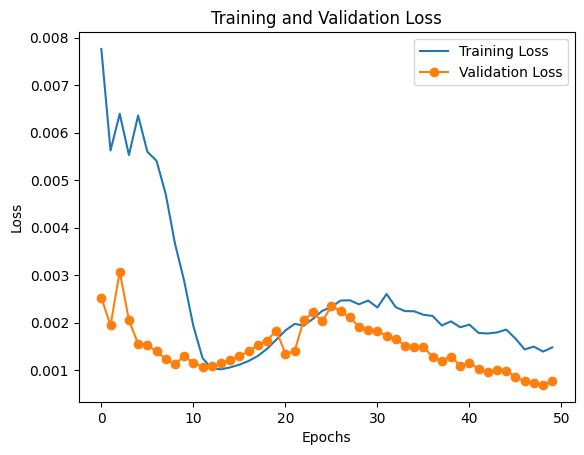

Test Result: MSE: 0.16084112226963043, RMSE: 0.401050024647338 




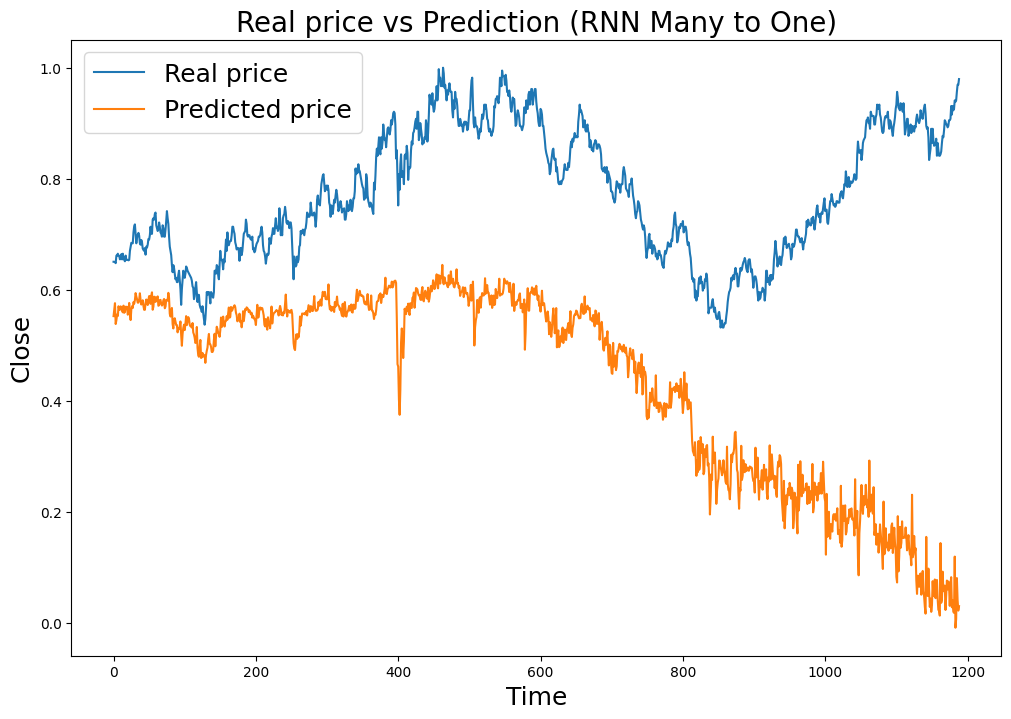

In [72]:
#Experiment 1b : Many to One
input_size_rnn_exp_2 = len(training_cols_many_to_one)
output_size_rnn_exp_2 = len(pred_cols_many_to_one)
hidden_size_rnn_exp_2 = 25
n_layer_rnn_2 = 2

#Model 2
model_2 = getRNNModel(input_size_rnn_exp_2, 
                      output_size_rnn_exp_2, 
                      hidden_size_rnn_exp_2, 
                      n_layer = n_layer_rnn_2)

lr = 0.001
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=lr)
rnnresult_2 = start_training(model_2, 
                          optimizer_2, 
                          train_many_to_one_dl, 
                          val_many_to_one_dl, 
                          epoch = 50)

#plot training loss
plot_training_loss(rnnresult_2)

#plot test results
get_test_results(model_2, test_many_to_one_dl, '(RNN Many to One)')

Epoch [5], train_MSE: 0.0072, val_MSE: 0.0031
Epoch [10], train_MSE: 0.0081, val_MSE: 0.0028
Epoch [15], train_MSE: 0.0107, val_MSE: 0.0043
Epoch [20], train_MSE: 0.0126, val_MSE: 0.0048
Epoch [25], train_MSE: 0.0122, val_MSE: 0.0050
Epoch [30], train_MSE: 0.0125, val_MSE: 0.0052
Epoch [35], train_MSE: 0.0125, val_MSE: 0.0051
Epoch [40], train_MSE: 0.0128, val_MSE: 0.0049
Epoch [45], train_MSE: 0.0131, val_MSE: 0.0054
Epoch [50], train_MSE: 0.0134, val_MSE: 0.0053


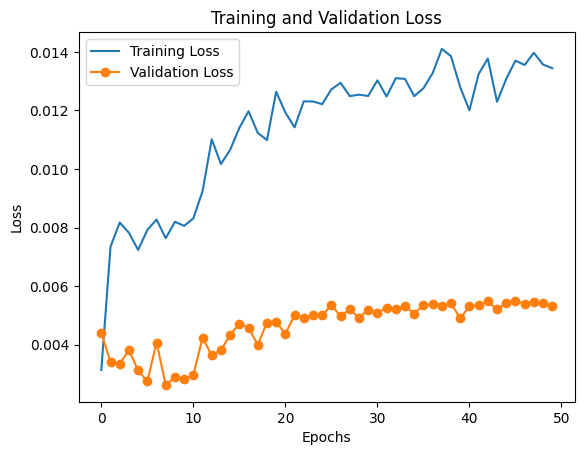

Test Result: MSE: 0.07441642135381699, RMSE: 0.2727937340809297 




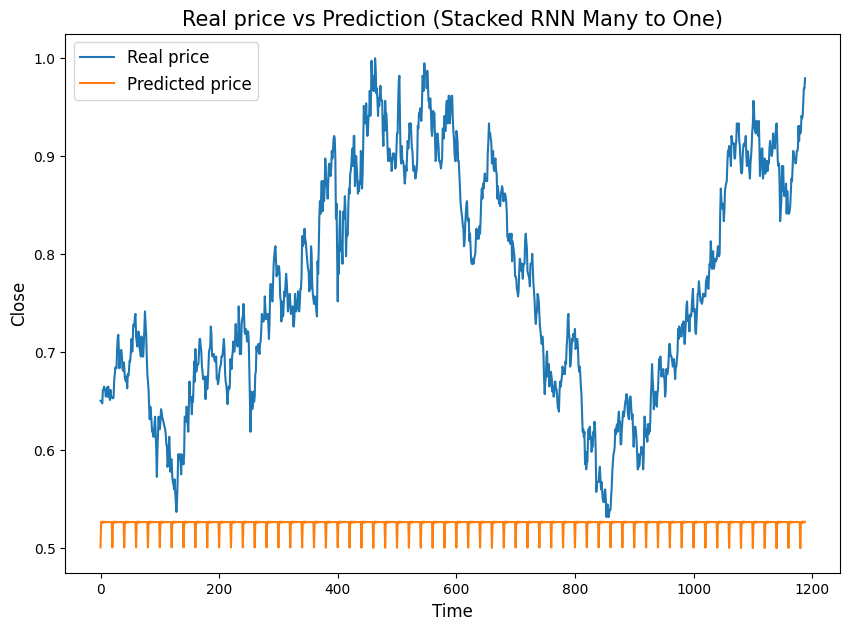

In [86]:
#Experiment 1c : Multilayer
input_size_rnn_exp_3 = len(training_cols_many_to_one)
output_size_rnn_exp_3 = len(pred_cols_many_to_one)
hidden_size_rnn_exp_3 = 25
n_layer_rnn_3 = 5

#Model 3 
model_3 = getRNNModel(input_size_rnn_exp_3, 
                      output_size_rnn_exp_3, 
                      hidden_size_rnn_exp_3, 
                      n_layer = n_layer_rnn_3)

lr = 0.001
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=lr)
rnnresult_3 = start_training(model_3, 
                          optimizer_3, 
                          train_many_to_one_dl, 
                          val_many_to_one_dl, 
                          epoch = 50)

#plot training loss
plot_training_loss(rnnresult_3)

#plot test results
get_test_results(model_3, test_many_to_one_dl, '(Stacked RNN Many to One)')

## LSTM 

Epoch [5], train_MSE: 0.0482, val_MSE: 0.0072
Epoch [10], train_MSE: 0.0081, val_MSE: 0.0021
Epoch [15], train_MSE: 0.0052, val_MSE: 0.0012
Epoch [20], train_MSE: 0.0022, val_MSE: 0.0007
Epoch [25], train_MSE: 0.0016, val_MSE: 0.0006
Epoch [30], train_MSE: 0.0017, val_MSE: 0.0006
Epoch [35], train_MSE: 0.0018, val_MSE: 0.0006
Epoch [40], train_MSE: 0.0020, val_MSE: 0.0007
Epoch [45], train_MSE: 0.0017, val_MSE: 0.0006
Epoch [50], train_MSE: 0.0015, val_MSE: 0.0005


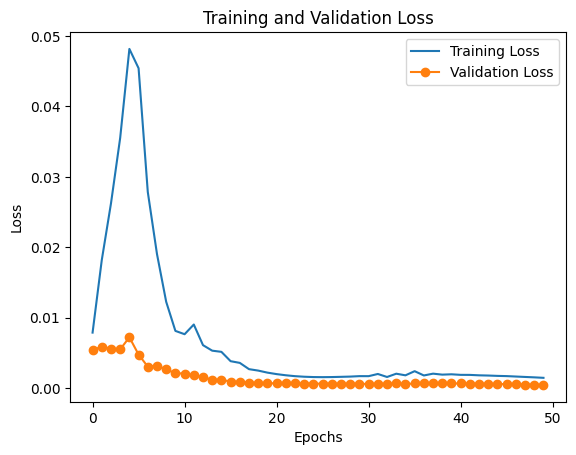

Test Result: MSE: 0.018208393827080727, RMSE: 0.1349384816391556 




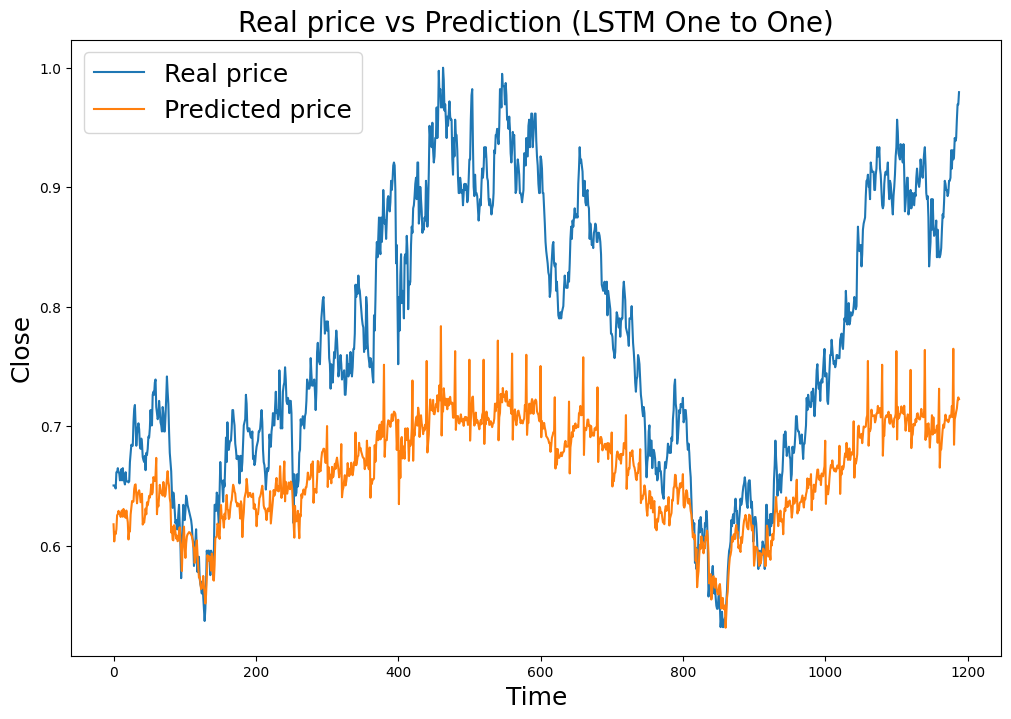

In [74]:
#Experiment 2a : One to One
input_size_lstm_exp_1 = len(training_cols_one_to_one)
output_size_lstm_exp_1 = len(pred_cols_one_to_one)
hidden_size_lstm_exp_1 = 25
n_layer_1 = 2

#Model 1
lstmmodel_1 = getLSTMModel(input_size_lstm_exp_1, 
                           output_size_lstm_exp_1, 
                           hidden_size_lstm_exp_1, 
                           n_layer = n_layer_1)

lr = 0.001
lstm_optimizer_1 = torch.optim.Adam(lstmmodel_1.parameters(), lr=lr)
lstmresult_1 = start_training(lstmmodel_1, 
                              lstm_optimizer_1, 
                              train_one_to_one_dl, 
                              val_one_to_one_dl, 
                              epoch = 50)

#plot training loss
plot_training_loss(lstmresult_1)

#plot test results
get_test_results(lstmmodel_1, test_one_to_one_dl, '(LSTM One to One)')

Epoch [5], train_MSE: 0.0062, val_MSE: 0.0028
Epoch [10], train_MSE: 0.0029, val_MSE: 0.0009
Epoch [15], train_MSE: 0.0016, val_MSE: 0.0006
Epoch [20], train_MSE: 0.0011, val_MSE: 0.0005
Epoch [25], train_MSE: 0.0011, val_MSE: 0.0004
Epoch [30], train_MSE: 0.0011, val_MSE: 0.0004
Epoch [35], train_MSE: 0.0010, val_MSE: 0.0004
Epoch [40], train_MSE: 0.0009, val_MSE: 0.0003
Epoch [45], train_MSE: 0.0008, val_MSE: 0.0003
Epoch [50], train_MSE: 0.0008, val_MSE: 0.0003


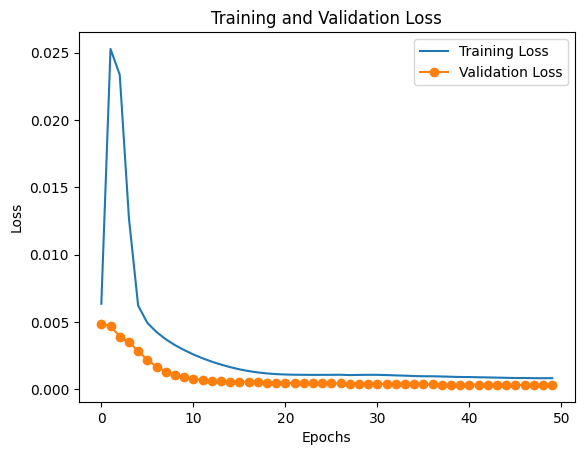

Test Result: MSE: 0.01594059355556965, RMSE: 0.12625606344080925 




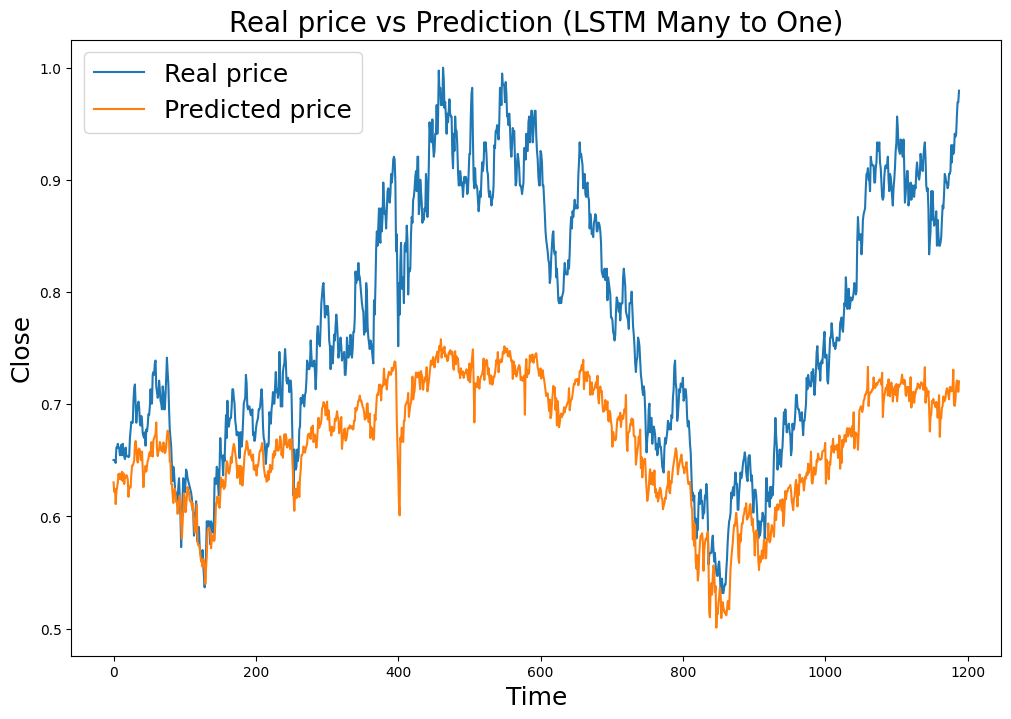

In [75]:
#Experiment 2b : Many to One
input_size_lstm_exp_2 = len(training_cols_many_to_one)
output_size_lstm_exp_2 = len(pred_cols_many_to_one)
hidden_size_lstm_exp_2 = 25
n_layer_2 = 2

#Model 2
lstmmodel_2 = getLSTMModel(input_size_lstm_exp_2, 
                           output_size_lstm_exp_2, 
                           hidden_size_lstm_exp_2, 
                           n_layer = n_layer_2)

lr = 0.001
lstm_optimizer_2 = torch.optim.Adam(lstmmodel_2.parameters(), lr=lr)
lstmresult_2 = start_training(lstmmodel_2, 
                              lstm_optimizer_2, 
                              train_many_to_one_dl, 
                              val_many_to_one_dl, 
                              epoch = 50)

#plot training loss
plot_training_loss(lstmresult_2)

#Displaying Test Results
get_test_results(lstmmodel_2, test_many_to_one_dl, '(LSTM Many to One)')


Epoch [5], train_MSE: 0.0821, val_MSE: 0.0028
Epoch [10], train_MSE: 0.0175, val_MSE: 0.0120
Epoch [15], train_MSE: 0.0162, val_MSE: 0.0157
Epoch [20], train_MSE: 0.0153, val_MSE: 0.0165
Epoch [25], train_MSE: 0.0152, val_MSE: 0.0177
Epoch [30], train_MSE: 0.0141, val_MSE: 0.0046
Epoch [35], train_MSE: 0.0072, val_MSE: 0.0082
Epoch [40], train_MSE: 0.0031, val_MSE: 0.0010
Epoch [45], train_MSE: 0.0024, val_MSE: 0.0013
Epoch [50], train_MSE: 0.0050, val_MSE: 0.0016


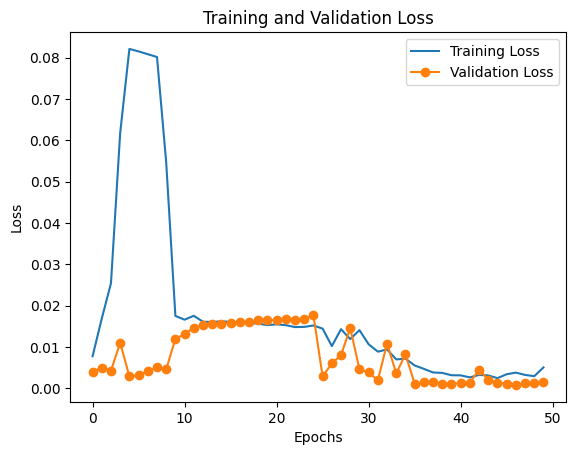

Test Result: MSE: 0.06827164441347122, RMSE: 0.2612884314574054 




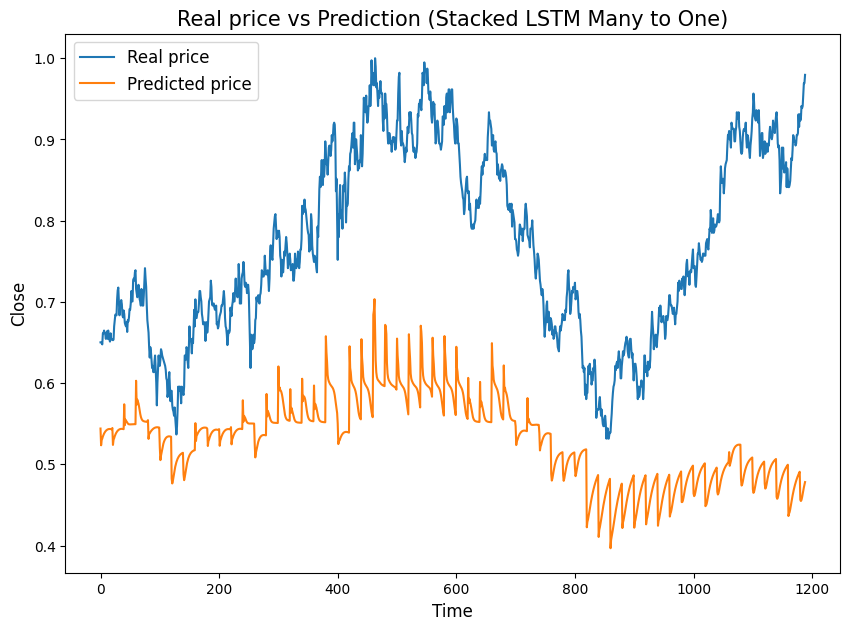

In [87]:
#Experiment 2c : Mutlilayer
input_size_lstm_exp_3 = len(training_cols_many_to_one)
output_size_lstm_exp_3 = len(pred_cols_many_to_one)
hidden_size_lstm_exp_3 = 25
n_layer_3 = 5

#Model 3
lstmmodel_3 = getLSTMModel(input_size_lstm_exp_3, 
                           output_size_lstm_exp_3, 
                           hidden_size_lstm_exp_3, 
                           n_layer = n_layer_3)

lr = 0.001
lstm_optimizer_3 = torch.optim.Adam(lstmmodel_3.parameters(), lr=lr)
lstmresult_3 = start_training(lstmmodel_3, 
                              lstm_optimizer_3, 
                              train_many_to_one_dl, 
                              val_many_to_one_dl, 
                              epoch = 50)

#plot training loss
plot_training_loss(lstmresult_3)

#plot test result
get_test_results(lstmmodel_3, test_many_to_one_dl, '(Stacked LSTM Many to One)')
